Alice souhaite s'initier aux graphes. Cependant toute cette théorie lui semble un peu obscure. Bob lui indique qu'une bonne manière de comprendre les graphes et des concepts mathématiques est de les coder.



Bob propose à Alice de visualiser ses graphes via la fonction suivante. Ceci demande cependant d'avoir une implémentation d'un graphe. Alice est totalement perdue et demande votre aide !

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph, colors = "cyan") :
	g = nx.DiGraph()
	g.add_nodes_from(graph.get_vertices())
	for k in graph.get_edges() :
		g.add_edge(*k, weight = graph.get_transition(*k))
	pos = nx.circular_layout(g)
	nx.draw_networkx_nodes(g, pos, node_color = colors)
	nx.draw_networkx_edges(g, pos, connectionstyle="arc3,rad=0.2")
	edge_labels = nx.get_edge_attributes(g, "weight")
	nx.draw_networkx_labels(g, pos)
	nx.draw_networkx_edge_labels(g, pos, edge_labels)
	plt.show()

Voici une classe de base pour vos graphes. Vous pourrez ensuite créer des graphes hérités pour utiliser vos graphes peu importe l'implémentation via vos fonctions.

In [2]:
class BaseGraph :
    
    def __init__(self) :
        # Empêche l'instantiation de cette classe abstraite
        raise TypeError("Unable to instantiate BaseGraph : must override it.")
    
    def add_vertex(self, v) :
        raise TypeError("add_vertex is not defined for BaseGraph : must override it.")
    
    def add_vertices(self, iterable) :
        for v in iterable :
            self.add_vertex(v)
    
    def remove_vertex(self, v) :
        raise TypeError("remove_vertex is not defined for BaseGraph : must override it.")
    
    def remove_vertices(self, iterable) :
        for v in iterable :
            if not self.remove_vertex(v) : return False
        return True
    
    def get_vertices(self) :
        raise TypeError("get_vertices is not defined for BaseGraph : must override it.")
    
    def has_vertex(self, v) :
        raise TypeError("has_vertex is not defined for BaseGraph : must override it.")
    
    def add_edge(self, u, v, transition = 1) :
        raise TypeError("add_edge is not defined for BaseGraph : must override it.")
    
    def add_edges(self, dictionary) :
        for k in dictionary :
            if not self.add_edge(*k, dictionary[k]) :
                return False
        return True
    
    def remove_edge(self, u, v) :
        raise TypeError("remove_edge is not defined for BaseGraph : must override it.")
    
    def remove_edges(self, iterable) :
        for e in iterable :
            if not self.remove_edge(*e) : return False
        return True
    
    def get_edges(self) :
        raise TypeError("get_edges is not defined for BaseGraph : must override it.")
    
    def has_edge(self, u, v) :
        raise TypeError("has_edge is not defined for BaseGraph : must override it.")
    
    def get_transition(self, u, v) :
        raise TypeError("get_transition is not defined for BaseGraph : must override it.")
    
    def neighbors(self, v) :
        raise TypeError("neighbors is not defined for BaseGraph : must override it.")
    
    def degree(self, v) :
        return len(self.neighbors(v))
    
    def constructor(self) :
        raise TypeError("Unable to instantiate BaseGraph : must override it.")
    
    def get_subgraph(self, vertices) :
        graph = self.constructor()
        vertices = {v for v in vertices if self.has_vertex(v)}
        graph.add_vertices(vertices)
        graph.add_edges({(a, b) : self.get_transition(a, b) for a, b in self.get_edges() if a in vertices and b in vertices})
        return graph
    
    def transpose(self) :
        raise TypeError("transpose is not defined for BaseGraph : must override it.")


Bob vous propose de commencer par une version simple de l'implémentation d'un graphe : depuis une définition ensembliste. Pour plus d'efficacité sur la gestion des poids / transitions, il vous suggère une table de hachage dont les clé sont les arcs et les valeurs sont les poids associés.

In [3]:
class SetGraph (BaseGraph) :
	
	def __init__(self) :
		self.vertices = set()
		self.edges = dict()
		
	def constructor(self) :
		return SetGraph()
	
	def add_edge(self, u, v, transition = 1) :
		if u not in self.vertices : return False
		if v not in self.vertices : return False
		self.edges[(u, v)] = transition
		return True
	
	def add_vertex(self, v) :
		self.vertices.add(v)
	
	def get_transition(self, u, v) :
		if (u, v) not in self.edges : return None
		return self.edges[(u, v)]
	
	def get_edges(self) :
		return self.edges
	
	def get_vertices(self) :
		return self.vertices
	
	def has_vertex(self, v) :
		return v in self.vertices
	
	def has_edge(self, u, v) :
		return (u, v) in self.edges
	
	def remove_edge(self, u, v) :
		if (u, v) not in self.edges : return False
		self.edges.pop((u, v))
		return True
	
	def remove_vertex(self, v) :
		if v not in self.vertices : return False
		self.remove_edges([(a, b) for a, b in self.edges if a == v or b == v])
		self.vertices.remove(v)
		return True
	
	def neighbors(self, v) :
		return {b for a, b in self.edges if a == v}
	
	def transpose(self) :
		graph = SetGraph()
		graph.add_vertices(self.get_vertices())
		graph.add_edges({(v, u) : self.get_transition(u, v) for (u, v) in self.get_edges()})
		return graph


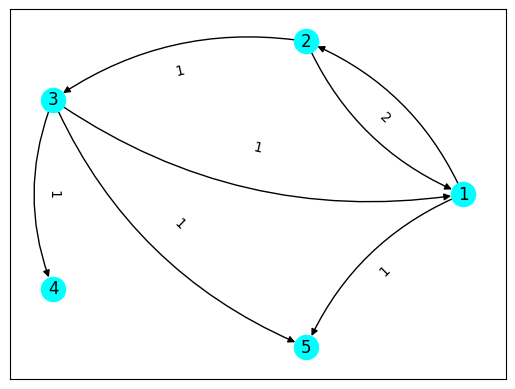

In [4]:
graph = SetGraph()
graph.add_vertices([1, 2, 3, 4, 5])
graph.add_edges({(1, 2) : 1, (2, 1) : 2, (2, 3) : 1, (3, 1) : 1, (3, 4) : 1, (3, 5) : 1, (1, 5) : 1})
draw_graph(graph)

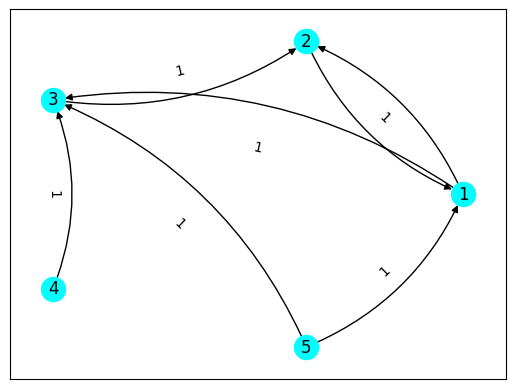

In [5]:
transposed_graph = graph.transpose()
draw_graph(transposed_graph)

Bob vous informe que dans certains cas, il peut être plus pertinent d'utiliser une matrice d'adjacence pour représenter les transitions entre les sommets.

In [6]:
class AdjacencyGraph(BaseGraph) :
	
	def __init__(self) :
		self.vertices = list()
		self.verticesSet = set()
		self.matrix = None
		
	def constructor(self) :
		return AdjacencyGraph()
	
	def add_vertex(self, v) :
		self.vertices.append(v)
		self.verticesSet.add(v)
		if self.matrix == None :
			self.matrix = [[None]]
		else :
			n = len(self.vertices) - 1
			self.matrix = [[self.matrix[i][j] if i < n and j < n else None for j in range(n + 1)] for i in range(n + 1)]
	
	def add_edge(self, u, v, transition = 1) :
		if u not in self.verticesSet : return False
		if v not in self.verticesSet : return False
		self.matrix[self.vertices.index(u)][self.vertices.index(v)] = transition
		return True
	
	def get_transition(self, u, v) :
		if u not in self.verticesSet : return None
		if v not in self.verticesSet : return None
		return self.matrix[self.vertices.index(u)][self.vertices.index(v)]
	
	def get_edges(self) :
		return {(self.vertices[i], self.vertices[j]):self.matrix[i][j] for i in range(len(self.vertices)) for j in range(len(self.vertices)) if self.matrix[i][j] != None}
	
	def get_vertices(self) :
		return self.verticesSet
	
	def has_vertex(self, v) :
		return v in self.verticesSet
	
	def has_edge(self, u, v) :
		if u not in self.verticesSet : return None
		if v not in self.verticesSet : return None
		return self.matrix[self.vertices.index(u)][self.vertices.index(v)] != None
	
	def remove_edge(self, u, v) :
		if not self.has_edge(u, v) : return False
		self.matrix[self.vertices.index(u)][self.vertices.index(v)] = None
		return True
	
	def remove_vertex(self, v) :
		if v not in self.verticesSet : return False
		pos = self.vertices.index(v)
		self.matrix = [[self.matrix[i][j] for j in range(len(self.vertices)) if j != pos] for i in range(len(self.vertices)) if i != pos]
		self.vertices.pop(pos)
		self.verticesSet.remove(v)
		return True
	
	def neighbors(self, v) :
		pos = self.vertices.index(v)
		return {self.vertices[i] for i in range(len(self.vertices)) if self.matrix[pos][i] != None}
	
	def transpose(self) :
		graph = AdjacencyGraph()
		graph.vertices = [e for e in self.vertices]
		graph.verticesSet = {e for e in self.verticesSet}
		graph.matrix = [[self.matrix[j][i] for j in range(len(self.get_vertices()))] for i in range(len(self.get_vertices()))]
		return graph

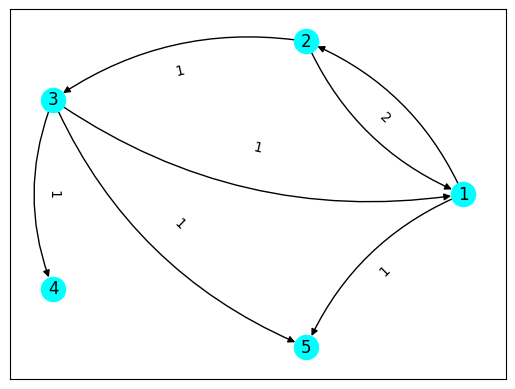

In [7]:
graph = AdjacencyGraph()
graph.add_vertices([1, 2, 3, 4, 5])
graph.add_edges({(1, 2) : 1, (2, 1) : 2, (2, 3) : 1, (3, 1) : 1, (3, 4) : 1, (3, 5) : 1, (1, 5) : 1})
draw_graph(graph)

Sauvegarder toute une matrice pour des graphes ayant peu de transitions ne serait pas toujours une bonne idée. Dans ce type de cas, Bob suggère d'utiliser une liste d'incidences. Tout sommet pourrait être une clé d'une table de hachage dont les valeurs sont les listes d'incidence. À noter que modéliser une liste d'incidence par une table de hachage pourrait être une idée pertinente (clé : nœud d'arrivée et valeur : la transition).

In [8]:
class IncidencyGraph (BaseGraph) :
	
	def __init__(self) :
		self.vertices = dict()
		
	def constructor(self) :
		return IncidencyGraph()
	
	def add_vertex(self, v) :
		self.vertices[v] = dict()
	
	def add_edge(self, u, v, transition = 1) :
		if u not in self.vertices : return False
		if v not in self.vertices : return False
		self.vertices[u][v] = transition
		return True
	
	def get_transition(self, u, v) :
		if u not in self.vertices : return None
		if v not in self.vertices[u] : return None
		return self.vertices[u][v]
	
	def get_edges(self) :
		return {(u, v) for u in self.vertices for v in self.vertices[u]}
	
	def get_vertices(self) :
		return self.vertices
	
	def has_vertex(self, v) :
		return v in self.vertices
	
	def has_edge(self, u, v) :
		return u in self.vertices and v in self.vertices[u]
	
	def remove_edge(self, u, v) :
		if not self.has_edge(u, v) : return False
		self.vertices[u].pop(v)
		return True
	
	def remove_vertex(self, v) :
		if not self.has_vertex(v) : return False
		for u in self.vertices :
			if v in self.vertices[u] :
				self.vertices[u].pop(v)
		self.vertices.pop(v)
		return True
	
	def neighbors(self, v) :
		return set(self.vertices[v].keys())
	
	def degree(self, v) :
		return len(self.vertices[v])
	
	def transpose(self) :
		graph = IncidencyGraph()
		graph.add_vertices(self.get_vertices())
		graph.add_edges({(v, u) : self.vertices[u][v] for u in self.vertices for v in self.vertices[u]})
		return graph

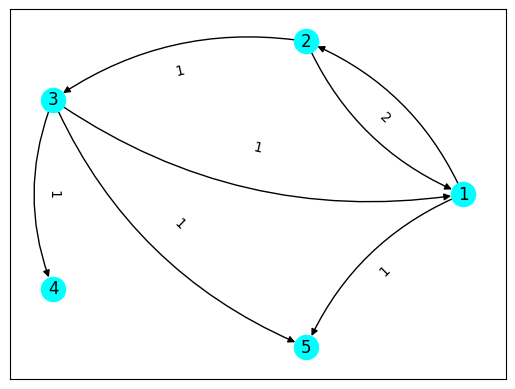

In [9]:
graph = IncidencyGraph()
graph.add_vertices([1, 2, 3, 4, 5])
graph.add_edges({(1, 2) : 1, (2, 1) : 2, (2, 3) : 1, (3, 1) : 1, (3, 4) : 1, (3, 5) : 1, (1, 5) : 1})
draw_graph(graph)

Testez le fonctionnement de vos graphes et créez un module AllGraphs qui importe le code produit précédemment pour la suite des exercices.

In [10]:
from AllGraphs import *
graphConstructor = IncidencyGraph

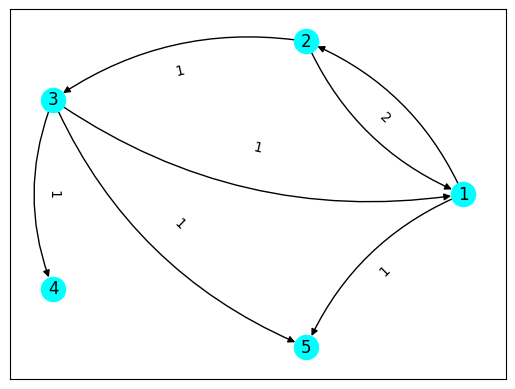

In [11]:
graph = graphConstructor()
graph.add_vertices([1, 2, 3, 4, 5])
graph.add_edges({(1, 2) : 1, (2, 1) : 2, (2, 3) : 1, (3, 1) : 1, (3, 4) : 1, (3, 5) : 1, (1, 5) : 1})
draw_graph(graph)